In [1]:
import config_imports
from astropy import units as u
from astropy.coordinates import SkyCoord, CartesianRepresentation, TEME
from astropy.time import Time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime


def to_datetime(eos_data: pd.DataFrame):
    eos_data["Datetime"] = eos_data[["Date", "Time", "Time since start (s)"]].apply(lambda x: datetime.datetime.fromisoformat(
        x.iloc[0] + "T" + x.iloc[1] + "Z") + datetime.timedelta(seconds=x.iloc[2] % 1.0), axis=1)
    eos_data = eos_data.drop(columns=["Date", "Time", "Time since start (s)"])
    return eos_data.set_index("Datetime", inplace=False)


eos_data_raw = pd.read_csv(r"EOS Sim Data\Sim2\sat_kinematic_state.CSV")


eos_data = eos_data_raw.drop(columns=["M11", "M12", "M13", "M21", "M22", "M23", "M31", "M32", "M33", 'M11.1', 'M12.1', 'M13.1', 'M21.1',
                                      'M22.1', 'M23.1', 'M31.1', 'M32.1', 'M33.1', 'X (deg/s).1', 'Y (deg/s).1', 'Z (deg/s).1'])

eos_data = to_datetime(eos_data).iloc[:20000, :]
time = eos_data.index
time_passed_hours = (time - time[0]).total_seconds()/(3600)

eos_data.columns

quat_OB = eos_data[['Q1', 'Q2', 'Q3', 'Q4']]
quat_OB /= np.linalg.norm(quat_OB, axis=1, keepdims=True)

omega_BO_deg = eos_data[['X (deg/s)', 'Y (deg/s)', 'Z (deg/s)']]

euler_OB = eos_data[['Roll (deg)', 'Pitch (deg)', 'Yaw (deg)']]

pos = eos_data[['X (km)', 'Y (km)', 'Z (km)']]
vel = eos_data[['X (km/s)', 'Y (km/s)', 'Z (km/s)']]

geocentric = eos_data[['Geocentric Latitude (deg)',
                       'Geodetic Latitude (deg)', 'Altitude (km)']]

orbit_elements = eos_data[['Eccentricity', 'Semi-major Axis (km)',
                           'Inclination (deg)', 'Right-ascension of Ascending Node (deg)',
                           'Argument of Perigee (deg)', 'True Anomaly (deg)',
                           'Radius of Perigee (km)', 'Radius of Apogee (km)',
                           'Perigee Altitude (km)', 'Apogee Altitude (km)']]

orbit_ang_rate = eos_data['Orbit Angular Rate (deg/s)']
# convert from TEME to GCRS inertial frame


def teme_to_gcrs(t: datetime.datetime, x_TEME):
    teme = TEME(obstime=Time(t, format="datetime", scale="utc"))
    x_ECI = SkyCoord(CartesianRepresentation(x_TEME[:, 0], x_TEME[:, 1], x_TEME[:, 2], unit=u.km), frame=teme,
                     representation_type='cartesian').transform_to("gcrs").cartesian.xyz.to(u.m).value  # type: ignore
    return x_ECI.T


pos_arr = teme_to_gcrs(time, np.array(pos))
vel_arr = teme_to_gcrs(time, np.array(vel))

In [2]:
aero_force = to_datetime(pd.read_csv(r"EOS Sim Data\Sim2\aero_force.CSV"))
aero_torque = to_datetime(pd.read_csv(r"EOS Sim Data\Sim2\aero_torque.CSV"))

srp_force = to_datetime(pd.read_csv(r"EOS Sim Data\Sim2\srp_force.CSV"))
srp_torque = to_datetime(pd.read_csv(r"EOS Sim Data\Sim2\srp_torque.CSV"))
# sun_vector1 = to_datetime(pd.read_csv(r"EOS Sim Data\Sim2\sun_sensor_sun_vec_1.CSV"))
# sun_vector2 = to_datetime(pd.read_csv(r"EOS Sim Data\Sim2\sun_sensor_sun_vec_2.CSV"))

qq_torque = to_datetime(pd.read_csv(r"EOS Sim Data\Sim2\gg_torque.CSV"))



In [3]:
import json
import os
import config_imports
from tqdm import tqdm
import environment as env
import disturbances as dis
from kinematics import eci_to_geodedic, orc_to_eci, orc_to_sbc, quaternion_kinematics, euler_ocr_to_sbc
from satellite import Spacecraft, replace_orientation_matrices
from simulation import Simulation, rk4_step
from scipy.spatial.transform import Rotation as R

with open(os.path.join(config_imports.PROJECT_DIR, "tudsat-trace_eos.json"), "r") as f:
            eos_file = json.load(f)

sim_init_data: dict = replace_orientation_matrices(eos_file) 

sim = Simulation.from_json(os.path.join(config_imports.PROJECT_DIR, "tudsat-trace_eos.json"))
sat = sim.sat

q_BI_true = np.empty((len(time), 4))

F_grav = np.empty((len(time), 3))
F_third = np.empty_like(F_grav)
tau_gg = np.empty_like(F_grav)
F_aero = np.empty_like(F_grav)
tau_aero =np.empty_like(F_grav)

rho = np.empty_like(F_grav)
sun_pos = np.empty_like(F_grav)
in_shadow = np.empty(len(time), dtype=bool)
F_SRP = np.empty_like(F_grav)
tau_SRP = np.empty_like(F_grav)

with tqdm(total=len(time), desc="Running") as pbar:
    for i, t in enumerate(time):


        q_BO_true = R.from_quat(quat_OB.iloc[i], scalar_first=False).inv()
        # orc_to_eci conversion is tested and good
        q_BI_true[i] = (q_BO_true * orc_to_eci(pos_arr[i], vel_arr[i]).inv()).as_quat(scalar_first=False)

        lat, lon, alt = eci_to_geodedic(pos_arr[i])
        
        rho[i] = env.atmosphere_density_msis(t, lat, lon, alt)
        # B = env.magnetic_field_vector(t, lat, lon, alt)
        sun_pos[i] = env.sun_position(t)
        in_shadow[i] = env.is_in_shadow(pos_arr[i], sun_pos[i])
        # moon_pos = env.moon_position(t)

        # F_grav[i] = dis.non_spherical_gravity_forces(pos_arr[i], sat.m)
        # F_third[i] = dis.third_body_forces(pos_arr[i], sat.m, sun_pos, moon_pos)
        # tau_gg[i] = dis.gravity_gradient(pos_arr[i], vel_arr[i], q_BI_true[i], sat.J_B)
        # F_aero[i], tau_aero[i] = dis.aerodynamic_drag(pos_arr[i], vel_arr[i], q_BI_true[i], sat.surfaces, rho[i])
        F_SRP[i], tau_SRP[i] = dis.solar_radiation_pressure(pos_arr[i], sun_pos[i], in_shadow[i], q_BI_true[i], sat.surfaces)

        pbar.update()


Running:   0%|          | 0/20000 [00:00<?, ?it/s]c:\Adaptive Satellite Control\adaptive-satellite-control\.venv\Lib\site-packages\pymsis\msis.py:380: UserWarning: no explicit representation of timezones available for np.datetime64
  dates_arr: npt.NDArray[np.datetime64] = np.atleast_1d(dates).astype(np.datetime64)
Running: 100%|██████████| 20000/20000 [02:51<00:00, 116.88it/s]


In [4]:
# plt.plot(time_passed_hours, sun_vector1.iloc[:, 1])
# # plt.show()
# plt.plot(time_passed_hours, sun_vector2.iloc[:, 1])

R_SS1 = np.array(((-1, 0, 0), (0, 0, -1), (0, 1, 0)))
R_SS2 = np.array(((1, 0, 0), (0, 0, 1), (0, 1, 0)))
sun_vec_EOS = (R_SS1 @ sun_vector1.to_numpy().T).T + (R_SS2 @ sun_vector2.to_numpy().T).T
plt.plot(time_passed_hours, sun_vec_EOS[:20000, 0])
plt.plot(time_passed_hours, sun_pos_B[:, 0])
# plt.xlim(0, 0.01)#

NameError: name 'sun_vector1' is not defined

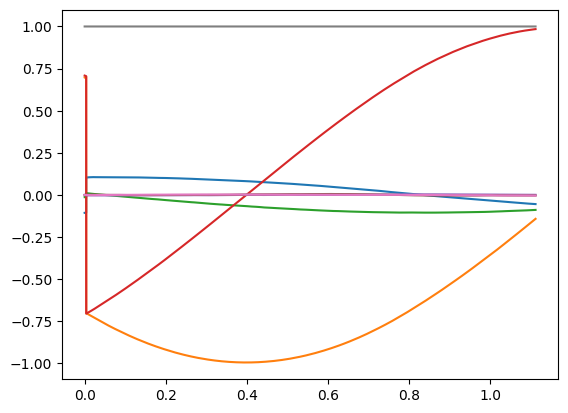

In [ ]:
plt.plot(time_passed_hours, q_BI_true)
plt.plot(time_passed_hours, quat_OB)

In [ ]:
# sun_pos in B frame
from kinematics import eci_to_sbc


sun_pos_B = eci_to_sbc(q_BI_true).apply((pos_arr - sun_pos) / 149597870700.0) 

plt.plot(time_passed_hours, sun_pos_B)


In [ ]:
from satellite import Surface

surface1 = Surface([0, 0, 0], 10, 10, np.eye(3))
surface2 = Surface([0, 0, 10], 10, 10, np.eye(3))


ray_dir = np.array([0, 0, 1])

is_occluded_1 = surface1.self_occlusion(ray_dir, [surface1, surface2])

is_occluded_2 = surface2.self_occlusion(ray_dir, [surface1, surface2])


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

surface1.plot(ax, color="k" if is_occluded_1 else "tab:green", normal_scale=0)
surface2.plot(ax, color="k" if is_occluded_2 else "tab:green", normal_scale=0)


for i in range(5):
    for j in range(5):
        ax.quiver(2*i+0.5, 2*j+0.5, -1, *ray_dir, color="r", length=5)

ax.set_ylabel("Y axis")
ax.set_xlabel("X axis")
ax.set_zlabel("Z axis")

ax.set_aspect("equal")
ax.legend()
fig.tight_layout()


(0.3, 0.45)

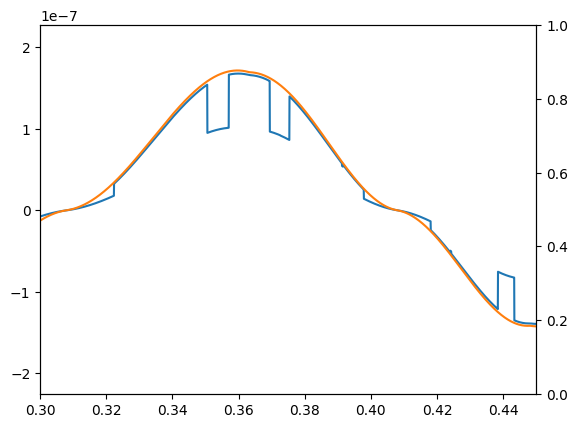

In [11]:
fix, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(time_passed_hours, F_SRP[:20000, 1])
ax1.plot(time_passed_hours, srp_force.iloc[:20000, 1])
ax1.set_xlim(0.3, 0.45)
# ax2.plot(time_passed_hours, q_BI_true)

In [ ]:
from satellite import Surface
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

new_panels = {
"Panel 1": {
        "$type": "Eos.Models.Satellite.CubeSatLibrary.CoverPanel, CubeSatLibrary",
        "DimX": 0.006,
        "DimY": 0.1,
        "NumSurfModelSegsX": 1,
        "NumSurfModelSegsY": 1,
        "HasHole": False,
        "HoleX": 0.0,
        "HoleY": 0.0,
        "HoleRadius": 0.0,
        "Position": [0.05, -0.05, 0.126],
        "Orientation":  [[0.00000000, 0.00000000, -1.00000000], 
                        [0.00000000, 1.00000000, 0.00000000], 
                        [1.00000000, 0.00000000, 0.00000000]]
        },
# "{X:0.05, Y:0.05, Z:0.12}",
#       "Orientation": "{{M11:0.00000000, M12:0.00000000, M13:-1.00000000}, {M21:-1.00000000, M22:0.00000000, M23:0.00000000}, {M31:0.00000000, M32:1.00000000, M33:0.00000000}}"
#     },
"Panel 2": {
        "$type": "Eos.Models.Satellite.CubeSatLibrary.CoverPanel, CubeSatLibrary",
        "DimX": 0.006,
        "DimY": 0.1,
        "NumSurfModelSegsX": 1,
        "NumSurfModelSegsY": 1,
        "HasHole": False,
        "HoleX": 0.0,
        "HoleY": 0.0,
        "HoleRadius": 0.0,
        "Position": [0.05, 0.05, 0.126],
        "Orientation":  [[0.00000000, 0.00000000, -1.00000000], 
                        [-1.00000000, 0.00000000, 0.00000000], 
                        [0.00000000, 1.00000000, 0.00000000]]
        },
# "{X:0.05, Y:-0.05, Z:0.02}",
#       "Orientation": "{{M11:0.00000000, M12:0.00000000, M13:1.00000000}, {M21:-1.00000000, M22:0.00000000, M23:0.00000000}, {M31:0.00000000, M32:-1.00000000, M33:0.00000000}}"
#     },
    "Panel 3": {
        "$type": "Eos.Models.Satellite.CubeSatLibrary.CoverPanel, CubeSatLibrary",
        "DimX": 0.006,
        "DimY": 0.1,
        "NumSurfModelSegsX": 1,
        "NumSurfModelSegsY": 1,
        "HasHole": False,
        "HoleX": 0.0,
        "HoleY": 0.0,
        "HoleRadius": 0.0,
        "Position": [-0.05, 0.05, 0.126],
        "Orientation":  [[0.00000000, 0.00000000, -1.00000000], 
                        [0.00000000, -1.00000000, 0.00000000], 
                        [-1.00000000, 0.00000000, 0.00000000]]
        },

    "Panel 4": {
        "$type": "Eos.Models.Satellite.CubeSatLibrary.CoverPanel, CubeSatLibrary",
        "DimX": 0.006,
        "DimY": 0.1,
        "NumSurfModelSegsX": 1,
        "NumSurfModelSegsY": 1,
        "HasHole": False,
        "HoleX": 0.0,
        "HoleY": 0.0,
        "HoleRadius": 0.0,
        "Position": [0.05, -0.05, 0.12],
        "Orientation":  [[0.00000000, 0.00000000, 1.00000000], 
                        [-1.00000000, 0.00000000, 0.00000000], 
                        [ 0.00000000, -1.00000000, 0.00000000]]
        },
}

new_sur = [Surface.from_eos_panel(v) for v in new_panels.values()]

for s in new_sur:
    s.plot(ax, color="tab:red", normal_scale=0.01)

for s in sat.surfaces:
    s.plot(ax, color="tab:blue", normal_scale=0.01)

ax.set_ylabel("Y axis")
ax.set_xlabel("X axis")
ax.set_zlabel("Z axis")
ax.set_zlim(0.11, 0.14)
ax.set_aspect("equal")
ax.legend()
fig.tight_layout()

In [ ]:
plt.plot(time_passed_hours, q_BI_true)